### Install required packages

In [ ]:
!pip install -q albumentations
!pip install -q efficientnet_pytorch
!pip install -q catalyst

     |████████████████████████████████| 446 kB 5.2 MB/s 
     |████████████████████████████████| 143 kB 55.2 MB/s 
     |████████████████████████████████| 125 kB 53.4 MB/s 


### Import modules

In [ ]:
import os
import cv2
import time
import json

from PIL import Image
from pathlib import Path

import warnings

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torchvision.utils import make_grid

from efficientnet_pytorch import EfficientNet

import albumentations as A
from albumentations.pytorch import ToTensorV2

from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.sampler import SequentialSampler

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore",category=UserWarning)
SEED=42
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### renaming cleanPV images

In [ ]:
def renameimages(collection,classname):
  for i,filename in enumerate(os.listdir(collection)):
    os.rename(f"{collection}/{filename}",f"{collection}/{classname}_{str(i)}.jpg")

In [ ]:
renameimages("/content/gdrive/My Drive/SolarData/Solar_Training/CleanPV","CleanPV")

#### renaming DirtyPV images


In [ ]:
renameimages("/content/gdrive/My Drive/SolarData/Solar_Training/DirtyPV","DirtyPV")

#### converting each RGBA image to RGB

In [ ]:
def convertRGBA2RGB(collection):
  #Check and convert each RGBA images to RGB
  for i,filename in enumerate(os.listdir(collection)):
    img=plt.imread(f"{collection}/{filename}")
    if len(img.shape)==4:
      img = Image.fromarray(np.array(Image.open(f"{collection}/{i}"))).convert('RGB')
      print(img.shape)
      img.save(f"{collection}/{i}")
      img.show()
      print(filename)

In [ ]:
convertRGBA2RGB("/content/gdrive/My Drive/SolarData/Solar_Training/CleanPV")

In [ ]:
convertRGBA2RGB("/content/gdrive/My Drive/SolarData/Solar_Training/DirtyPV")

### Download EfficientNet model

In [ ]:
def Net(model_name='b3',output=2):
    model=EfficientNet.from_pretrained(f'efficientnet-{model_name}')
    model._fc=nn.Linear(in_features=model._fc.in_features,
                        out_features=output,bias=True)
    return model
Net()    

### Load saved model

In [ ]:
def load_model(path):
  model = Net().cuda()
  model.load_state_dict(torch.load(path)["model_state_dict"])
  model.eval()
  return model

### Config class

In [ ]:
class Config:
  Train_DIR="/content/gdrive/My Drive/SolarData/Solar_Training/"
  TEST_DIR="/content/gdrive/My Drive/SolarData/DirtyAndCleanTest"
  clean=os.listdir("/content/gdrive/My Drive/SolarData/Solar_Training/CleanPV")
  dirty=os.listdir("/content/gdrive/My Drive/SolarData/Solar_Training/DirtyPV")[:880]
  output=5
  num_workers=4
  batch_size=32
  img_size=224
  n_epochs=200
  lr=0.0003
  patience=5
  SchedulerClass=torch.optim.lr_scheduler.ReduceLROnPlateau
  scheduler_params=dict(
      mode='min',
      factor=0.8,
      patience=1,
      verbose=True,
      threshold=0.0001,
      threshold_mode='abs',
      cooldown=0,
      min_lr=1e-8,
      eps=1e-08
  )

### Create a dataset of image names and class labels 

In [ ]:
# create a dataframe with the image names and labels
df=pd.DataFrame(Config.clean,columns=["img_IDS"])
df["Label"]=0
df2=pd.DataFrame(Config.dirty,columns=["img_IDS"])
df2["Label"]=1
df=df.append(df2)
df=df.reset_index()
df

,index,img_IDS,Label
0,0,CleanPV_0.jpg,0
1,1,CleanPV_1.jpg,0
2,2,CleanPV_2.jpg,0
3,3,CleanPV_3.jpg,0
4,4,CleanPV_4.jpg,0
...,...,...,...
1755,875,DirtyPV_875.jpg,1
1756,876,DirtyPV_876.jpg,1
1757,877,DirtyPV_877.jpg,1
1758,878,DirtyPV_878.jpg,1


In [ ]:
df['Label'].value_counts()

0    880
1    880
Name: Label, dtype: int64

### Dataloader

In [ ]:
class SolarDataset(Dataset):
  def __init__(self,image_ids,labels,mode="train",transforms=None):
    super().__init__()
    self.image_ids=image_ids
    self.labels=labels
    self.mode=mode
    self.transforms=transforms

  def __getitem__(self,idx:int):
    image_id=self.image_ids[idx]
    if self.mode=="train" or self.mode=="val":
      if image_id in Config.clean:
        folder_name='CleanPV'
      elif image_id in Config.dirty:
        folder_name='DirtyPV'
      image=cv2.imread(f'{Config.Train_DIR}{folder_name}/{image_id}')    
      image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      label=self.labels[idx]
      if self.transforms:
        sample={'image':image}
        sample=self.transforms(**sample)
        image=sample['image']
      return image,label  

    elif self.mode=="test":
      image=cv2.imread(f'{Config.TEST_DIR}/{image_id}')    
      image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      if self.transforms:
        sample={'image':image}
        sample=self.transforms(**sample)
        image=sample['image']
  
      return image


  def __len__(self)->int:
    return self.image_ids.shape[0]    

  def get_labels(self):
    return list(self.labels)   

### Augmentations

In [ ]:
def train_augmentations(img_size=224):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1),
        A.RandomSizedCrop(min_max_height=(int(img_size-0.2*img_size), int(img_size-0.2*img_size)),
                          height=img_size, width=img_size, p=0.5),  
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.CoarseDropout(max_holes=8, max_width=12,
                        max_height=12, fill_value=0, p=0.5),
        ToTensorV2(p=1.0),
    ], p=1.0)


def validation_augumentations(img_size=224):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1.0),
        ToTensorV2(p=1.0),
    ], p=1.0)

In [ ]:
df.img_IDS.values

array(['CleanPV_0.jpg', 'CleanPV_1.jpg', 'CleanPV_2.jpg', ...,
       'DirtyPV_877.jpg', 'DirtyPV_878.jpg', 'DirtyPV_879.jpg'],
      dtype=object)

0


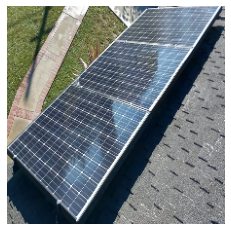

In [ ]:
obj = SolarDataset(df.img_IDS.values, df.Label.values,
                       mode="train",transforms=validation_augumentations())
images, labels = obj[500]
plt.imshow(images.numpy().transpose(1, 2, 0))
plt.axis('off')
print(labels)

In [ ]:
#Helper Function 
#this is just a good practice of calcualting and storing the values. Not a compulsion. Check ImageNet code from pytorch examples for more info
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#Train Loader    
train_loss=dict()
valid_loss=dict()
accuracy_dict=dict()

class Train:
    
    def __init__(self,model,device,config,fold,model_name='b3',image_size=224, weight_path='./'):
  
        self.model=model
        self.device=device
        self.config=config
        self.best_score=0
        self.best_loss=5000
        self.fold=fold
        self.model_name = model_name
        self.predictions=list()
        self.image_size = image_size
        self.weight_path = weight_path
        

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)

        print("Model loaded")
            
        
    def fit(self,train_loader,validation_loader):
        for epoch in range(self.config.n_epochs):

            print("Training Started...")
            t=time.time()
            Loss = self.train_one_epoch(train_loader)
            # acc=self.train_one_epoch(train_loader)
            train_loss[epoch] = Loss.avg

            print(f'Train : Epoch {epoch}: | Loss: {Loss.avg}  | Training time: {time.time()-t}')
            
            t=time.time()
            print("Validation Started...")
            Loss,Acc = self.validation(validation_loader)

            valid_loss[epoch] = Loss.avg
            accuracy_dict[epoch]=Acc.avg

            print(f'Valid : Epoch {epoch}: | Loss: {Loss.avg} | Accuracy: {Acc.avg} | Training time: {time.time()-t}')
            
            self.scheduler.step(metrics=Loss.avg)
            
            if not self.best_score:
                self.best_score = Loss.avg
                print(f'Saving model with best CE Loss as {self.best_score}')
                self.model.eval()   
                patience = self.config.patience
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
                continue  

            if Loss.avg <= self.best_score:
                self.best_score = Loss.avg
                patience = self.config.patience
                print('Improved model with best CE loss as {}'.format(self.best_score))
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
            else:
                patience -= 1
                print('Patience Reduced')
                if patience == 0:
                    print(f'Early stopping. Best CE Loss: {self.best_score}')
                    break    
                    
    def validation(self, val_loader):
        self.model.eval()
        Loss = AverageMeter()
        Acc=AverageMeter()

        t = time.time()

        for steps,(images, targets) in enumerate(tqdm(val_loader)):
            with torch.no_grad():
                targets = targets.to(self.device, dtype=torch.long)
                batch_size = images.shape[0]               
                images = images.to(self.device, dtype=torch.float32)
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                Loss.update(loss.detach().item(), batch_size)
                _,preds=torch.max(outputs,dim=1)
                Acc.update(torch.sum(preds == targets).item() / len(preds))
            
        return Loss,Acc

    def train_one_epoch(self, train_loader):
        self.model.train()

        Loss = AverageMeter()

        t = time.time()

#         print("hello before vala")
        for steps,(images, targets) in enumerate(tqdm(train_loader)):
#             print("hello after ")
#             targets=torch.tensor(targets)
#             print(type(targets))
            targets = torch.tensor(targets).to(self.device,dtype=torch.long)
#             print(type(targets))
            

            batch_size = images.shape[0]        
            images = images.to(self.device, dtype=torch.float32)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            Loss.update(loss.detach().item(), batch_size)

        return Loss 

    def evaluate_model(self,val_loader):
      for _,x_val in enumerate(val_loader):
        temp=list()
        test_images = x_val.to(torch.device('cuda'), dtype=torch.float32)
        pred = self.model(test_images)
        y_pred = nn.functional.softmax(pred, dim=1).data.cpu().numpy()

        for each_pred in y_pred:
          temp.append(each_pred.argmax())

        self.predictions.extend(temp)
      return self.predictions  


### Stratified KFold

In [ ]:
train_df=df
train_df.head()
class_names={"0":"CleanPV","1":"DirtyPV"}

In [ ]:
test_csv=pd.read_csv("/content/gdrive/My Drive/SolarData/test.csv")
train_df['label_name'] = train_df['Label'].apply(lambda x: class_names[str(x)])
test_csv['label_name'] = test_csv['Label'].apply(lambda x: class_names[str(x)])
test_csv.head()

,index,img_IDS,Label,label_name
0,0,CleanPV-TEST-(24).jpg,0,CleanPV
1,1,CleanPV-TEST-(6).jpg,0,CleanPV
2,2,CleanPV-TEST-(32).jpg,0,CleanPV
3,3,CleanPV-TEST-(20).jpg,0,CleanPV
4,4,CleanPV-TEST-(23).jpg,0,CleanPV


In [ ]:
sk = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
for fold, (train, val) in enumerate(sk.split(train_df, train_df['Label'])):
    train_df.loc[val, 'fold'] = fold
train_df.fold = train_df.fold.astype(int)
train_df.fold.value_counts()

1    440
3    440
0    440
2    440
Name: fold, dtype: int64

In [ ]:
sk = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
for fold, (train, val) in enumerate(sk.split(test_csv, test_csv['Label'])):
    test_csv.loc[val, 'fold'] = fold
test_csv.fold = test_csv.fold.astype(int)
test_csv.fold.value_counts()

0    31
1    31
3    30
2    30
Name: fold, dtype: int64

In [ ]:
def test(fold_number=0,model_name='b3',image_size=512,weight_path='./',load_weights_path=None):
    train_X = train_df[train_df['fold'] != fold_number].img_IDS.values
    train_Y = train_df[train_df['fold'] != fold_number].Label.values
    valid_X = train_df[train_df['fold'] == fold_number].img_IDS.values
    valid_Y = train_df[train_df['fold'] == fold_number].Label.values


    train_dataset=SolarDataset(train_X,train_Y,mode="train",transforms=train_augmentations(img_size=image_size))
    valid_dataset=SolarDataset(valid_X,valid_Y,mode="val",transforms=validation_augumentations(img_size=image_size))
    

    train_loader=torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(),mode='downsampling'),
        batch_size=Config.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=Config.num_workers,
    )
    validation_loader=torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
    )
    model=Net(model_name=model_name).cuda()
    if load_weights_path is not None:
        model.load_state_dict(torch.load(load_weights_path + f"{image_size} {model_name}_{fold_number}.pt")["model_state_dict"])
        print("Weight Loaded")
    engine = Train(model=model, device=torch.device('cuda'), config=Config, fold=fold_number,
    model_name=model_name, image_size=image_size, weight_path=weight_path)
    engine.fit(train_loader, validation_loader)

### Evaluation on Test Dataset

In [ ]:
def performance(fold_number):
  valid_test_X=test_csv[test_csv['fold'] == fold_number].img_IDS.values
  valid_test_Y=test_csv[test_csv['fold'] == fold_number].Label.values

  test_dataset=SolarDataset(valid_test_X,valid_test_Y,mode="test",transforms=validation_augumentations(img_size=224))

  validation_loader=torch.utils.data.DataLoader(
        test_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(test_dataset),
        pin_memory=False,
    )
  model=load_model(f'/content/gdrive/My Drive/SolarData/EfficientNet_224_b3_0.pt')
  engine = Train(model=model, device=torch.device('cuda'), config=Config, fold=fold_number,
  model_name='b3', image_size=224, weight_path='./')
  pred = engine.evaluate_model(validation_loader)
  return pred,valid_test_Y

In [ ]:
test(fold_number=0,model_name='b3',image_size=224)

Loaded pretrained weights for efficientnet-b3
Model loaded
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 0: | Loss: 0.4128814783038163  | Training time: 107.83643198013306
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 0: | Loss: 2.052400070428848 | Accuracy: 0.5141369047619048 | Training time: 39.60587430000305
Saving model with best CE Loss as 2.052400070428848
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 1: | Loss: 0.1965692599372166  | Training time: 27.156317472457886
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 1: | Loss: 1.0357590794563294 | Accuracy: 0.697172619047619 | Training time: 10.798516988754272
Improved model with best CE loss as 1.0357590794563294
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 2: | Loss: 0.1664673427983028  | Training time: 30.221356630325317
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 2: | Loss: 0.6375836404887113 | Accuracy: 0.7931547619047619 | Training time: 9.621436595916748
Improved model with best CE loss as 0.6375836404887113
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 3: | Loss: 0.11200299173048357  | Training time: 29.872427225112915
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 3: | Loss: 0.25537291460416534 | Accuracy: 0.9129464285714286 | Training time: 8.617878913879395
Improved model with best CE loss as 0.25537291460416534
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 4: | Loss: 0.0929477306355427  | Training time: 25.56802272796631
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 4: | Loss: 0.22023067301647228 | Accuracy: 0.9389880952380952 | Training time: 7.660879373550415
Improved model with best CE loss as 0.22023067301647228
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 5: | Loss: 0.07949264733711393  | Training time: 26.23225212097168
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 5: | Loss: 0.2633667960085652 | Accuracy: 0.9441964285714286 | Training time: 7.663911581039429
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 6: | Loss: 0.07376797071362777  | Training time: 26.461244821548462
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 6: | Loss: 0.29814681912010366 | Accuracy: 0.9285714285714286 | Training time: 7.675318956375122
Epoch 00007: reducing learning rate of group 0 to 2.4000e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 7: | Loss: 0.08589902210117477  | Training time: 25.935922384262085
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 7: | Loss: 0.28159718547355045 | Accuracy: 0.927827380952381 | Training time: 7.642003059387207
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 8: | Loss: 0.08698380509073414  | Training time: 25.661628007888794
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 8: | Loss: 0.1971166383813728 | Accuracy: 0.9419642857142857 | Training time: 7.598645448684692
Improved model with best CE loss as 0.1971166383813728
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 9: | Loss: 0.04242413364941391  | Training time: 27.149762868881226
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 9: | Loss: 0.24150397916409103 | Accuracy: 0.943452380952381 | Training time: 8.355456352233887
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 10: | Loss: 0.03775213003476582  | Training time: 25.79674482345581
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 10: | Loss: 0.241342776438052 | Accuracy: 0.9441964285714286 | Training time: 7.6639134883880615
Epoch 00011: reducing learning rate of group 0 to 1.9200e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 11: | Loss: 0.04822263688916659  | Training time: 25.685322761535645
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 11: | Loss: 0.28065656863830307 | Accuracy: 0.9389880952380952 | Training time: 7.621375799179077
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 12: | Loss: 0.03643028150176311  | Training time: 26.087133646011353
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 12: | Loss: 0.25737746219066054 | Accuracy: 0.9486607142857143 | Training time: 7.655756711959839
Epoch 00013: reducing learning rate of group 0 to 1.5360e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 13: | Loss: 0.030183651024566556  | Training time: 25.684903144836426
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 13: | Loss: 0.24385664950717578 | Accuracy: 0.9456845238095238 | Training time: 7.625664710998535
Patience Reduced
Early stopping. Best CE Loss: 0.1971166383813728


In [ ]:
test(fold_number=1,model_name='b3',image_size=224)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Loaded pretrained weights for efficientnet-b3
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 0: | Loss: 0.42308092662474006  | Training time: 26.13352394104004
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 0: | Loss: 1.7820925875143572 | Accuracy: 0.53125 | Training time: 8.247232913970947
Saving model with best CE Loss as 1.7820925875143572
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 1: | Loss: 0.2036272950652169  | Training time: 26.28207492828369
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 1: | Loss: 0.7171519463712519 | Accuracy: 0.703125 | Training time: 8.228117227554321
Improved model with best CE loss as 0.7171519463712519
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 2: | Loss: 0.15686089086641625  | Training time: 26.15290117263794
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 2: | Loss: 0.5230371941219677 | Accuracy: 0.7938988095238095 | Training time: 8.262897729873657
Improved model with best CE loss as 0.5230371941219677
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 3: | Loss: 0.1411024330229294  | Training time: 25.811781406402588
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 3: | Loss: 0.24774193845011971 | Accuracy: 0.9107142857142857 | Training time: 8.317639350891113
Improved model with best CE loss as 0.24774193845011971
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 4: | Loss: 0.1092589403979662  | Training time: 25.67228412628174
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 4: | Loss: 0.16721014515920118 | Accuracy: 0.9389880952380952 | Training time: 8.207430601119995
Improved model with best CE loss as 0.16721014515920118
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 5: | Loss: 0.07086391796971239  | Training time: 26.53119158744812
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 5: | Loss: 0.21882980743592437 | Accuracy: 0.9389880952380952 | Training time: 8.242992401123047
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 6: | Loss: 0.07005662943531828  | Training time: 29.550914525985718
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 6: | Loss: 0.2078088647939942 | Accuracy: 0.9345238095238095 | Training time: 8.146576404571533
Epoch 00007: reducing learning rate of group 0 to 2.4000e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 7: | Loss: 0.086679003315001  | Training time: 26.333800077438354
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 7: | Loss: 0.15745184496045111 | Accuracy: 0.9516369047619048 | Training time: 8.207091331481934
Improved model with best CE loss as 0.15745184496045111
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 8: | Loss: 0.057900070190066245  | Training time: 25.75359535217285
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 8: | Loss: 0.17100431756539777 | Accuracy: 0.9382440476190476 | Training time: 8.280885696411133
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 9: | Loss: 0.049478975573282055  | Training time: 26.679291009902954
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 9: | Loss: 0.164066763154485 | Accuracy: 0.9382440476190476 | Training time: 8.12812066078186
Epoch 00010: reducing learning rate of group 0 to 1.9200e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 10: | Loss: 0.05382004571601567  | Training time: 27.88296413421631
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 10: | Loss: 0.1626944210041653 | Accuracy: 0.9360119047619048 | Training time: 8.215707063674927
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 11: | Loss: 0.03504093877244287  | Training time: 25.930609941482544
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 11: | Loss: 0.14706816293976524 | Accuracy: 0.9404761904761905 | Training time: 8.226809740066528
Improved model with best CE loss as 0.14706816293976524
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 12: | Loss: 0.034047006493116296  | Training time: 25.52458095550537
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 12: | Loss: 0.17789319553835825 | Accuracy: 0.9449404761904762 | Training time: 8.618192434310913
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 13: | Loss: 0.028939017054920153  | Training time: 26.32731533050537
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 13: | Loss: 0.20993816217576916 | Accuracy: 0.943452380952381 | Training time: 8.323536396026611
Epoch 00014: reducing learning rate of group 0 to 1.5360e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 14: | Loss: 0.025938500789357576  | Training time: 26.45757007598877
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 14: | Loss: 0.18494457771832293 | Accuracy: 0.9412202380952381 | Training time: 8.197947263717651
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 15: | Loss: 0.02726132398976649  | Training time: 26.28839874267578
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 15: | Loss: 0.1975005475973541 | Accuracy: 0.9389880952380952 | Training time: 8.323317527770996
Epoch 00016: reducing learning rate of group 0 to 1.2288e-04.
Patience Reduced
Training Started...


  0%|          | 0/41 [00:00<?, ?it/s]

Train : Epoch 16: | Loss: 0.02036171693854579  | Training time: 26.347809076309204
Validation Started...


  0%|          | 0/14 [00:00<?, ?it/s]

Valid : Epoch 16: | Loss: 0.17719664395871487 | Accuracy: 0.9479166666666667 | Training time: 8.295006275177002
Patience Reduced
Early stopping. Best CE Loss: 0.14706816293976524


Validation accuracy,▁▄▇████████████
Validation loss:,█▆▂▁▂▂▁▁▁▁▁▁▂▁▂
Validation accuracy,0.93899
Validation loss:,0.1975


In [ ]:
pred_0, true_0=performance(0)
pred_1,true_1=performance(1)
pred_2,true_2=performance(2)
pred_3,true_3=performance(3)

Loaded pretrained weights for efficientnet-b3
Model loaded
Loaded pretrained weights for efficientnet-b3
Model loaded
Loaded pretrained weights for efficientnet-b3
Model loaded
Loaded pretrained weights for efficientnet-b3
Model loaded


In [ ]:
pred_all = np.concatenate((pred_0, pred_1, pred_2, pred_3), axis=0)
true_all = np.concatenate((true_0, true_1, true_2, true_3), axis=0)

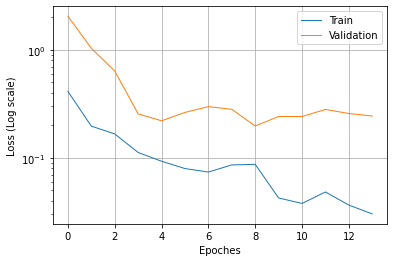

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(train_loss.keys()), list(train_loss.values()), linewidth=1, label="Train")
plt.plot(list(valid_loss.keys()), list(valid_loss.values()),  linewidth=1, label="Validation")
# plt.suptitle('Fold : 0 ')
plt.xlabel('Epoches')
plt.ylabel('Loss (Log scale)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

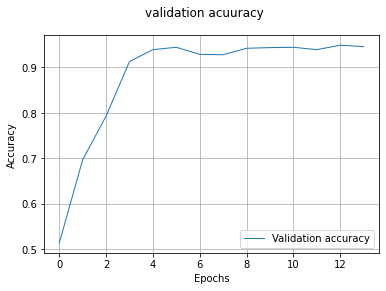

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(accuracy_dict.keys()),list(accuracy_dict.values()),linewidth=1,label="Validation accuracy")
plt.suptitle("validation acuuracy ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.87      0.91        61
           1       0.88      0.95      0.91        61

    accuracy                           0.91       122
   macro avg       0.91      0.91      0.91       122
weighted avg       0.91      0.91      0.91       122

[[53  8]
 [ 3 58]]


[Text(0, 0.5, 'DirtyPV'), Text(0, 1.5, 'CleanPV')]

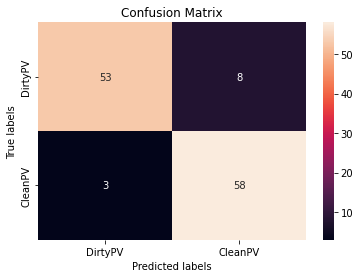

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(true_all, pred_all))
cfm = confusion_matrix(true_all, pred_all)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['DirtyPV', 'CleanPV'])
ax.yaxis.set_ticklabels(['DirtyPV', 'CleanPV'])